# Kriging
#### Mickey MacKie, Stanford Radio Glaciology

Here we implement simple kriging for a case study on Niohalvfjerds-fjorden using variogram parameters from Variogram_model.ipynb. 

Kriging is a deterministic interpolation algorithm. (will elaborate).



In [1]:
# load dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.neighbors import LocalOutlierFactor
import geostatspy.geostats as geostats 

import GlacierStats as gs

## Load and plot data

In [2]:
df_bed = pd.read_csv('Data/Nioghalvfjerds_bed_data.csv') # download data

# remove outliers with LOF method
clf = LocalOutlierFactor(n_neighbors = 5, contamination = 0.05)
clf.fit_predict(df_bed)
lof = clf.negative_outlier_factor_
df_bed = df_bed[lof >= -1.3]

<function matplotlib.pyplot.show(*args, **kw)>

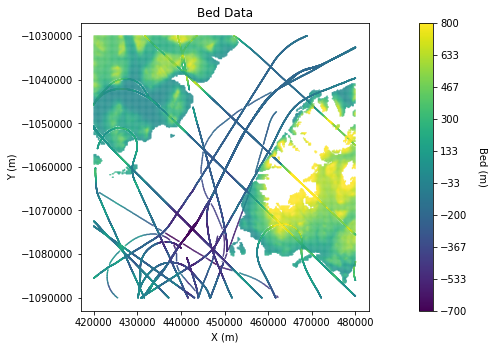

In [3]:
# plot data
im = plt.scatter(df_bed['X'],df_bed['Y'], c = df_bed['Bed'], vmin = -700, vmax = 800, marker=".", s = 0.5)       # scatter plot for location map
plt.title('Bed Data')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-700, 800, 10)) # add vertical color bar
cbar.set_label("Bed (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show

## Convert to standard Gaussian distribution

In [4]:
df_bed['Nbed'], tvbed, tnsbed = geostats.nscore(df_bed,'Bed')  # normal score transformation

## Set variogram parameters

These are the variogram model parameters we determined in Variogram_model.ipynb:

In [5]:
Azimuth = 22.5 # azimuthal direction of major axis
nug = 0 # nugget
nstruct = 2 # variogram structures
vtype = [1,2] # exponential type (1 = spherical, 2 = exponential, 3 = Guassian)
cc = [0.8,0.2] # contribution for each structure. nugget + cc = 1
a_max = [40000,50000] # major range for each structure
a_min = [25000,30000] # minor range for each structure

vario = [Azimuth, nug, nstruct, vtype, cc, a_max, a_min] # save variogram parameters as a list

## Kriging interpolation

First we need to define a grid to interpolate:

In [6]:
# define coordinate grid
xmin = 420000; xmax = 480000              # range of x values
ymin = -1090000; ymax = -1030000     # range of y values
pix = 500  # pixel resolution
Pred_grid_xy = gs.pred_grid(xmin, xmax, ymin, ymax, pix)

The bed measurement spacing is on the order of tens of meters, which is much finer than the the grid cell spacing. To produce a more stable kriging estimate, we randomly downsample the data to 10% of its original size

In [7]:
# randomly downsample data to 10% of the original size
df_samp = df_bed.sample(frac=0.10, replace=False, random_state=1)

Then we can perform kriging

In [8]:
k = 200 # number of neighboring data points used to estimate a given point 
est_SK, var_SK = gs.krige(Pred_grid_xy, df_samp, 'X', 'Y', 'Nbed', k, vario) # estimation and variance

100%|██████████| 14400/14400 [02:35<00:00, 92.86it/s] 


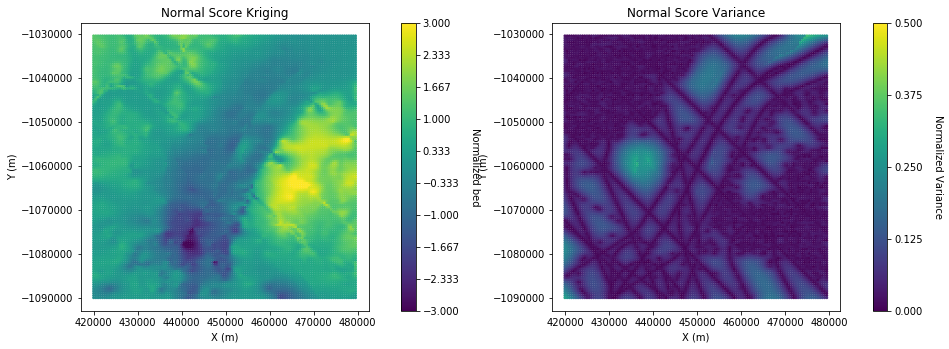

In [9]:
# plot results
plt.subplot(121) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = est_SK, vmin = -3, vmax = 3, marker=".", s = 15)       # scatter plot for location map
plt.title('Normal Score Kriging')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-3, 3, 10)) # add vertical color bar
cbar.set_label("Normalized bed", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplot(122) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = var_SK, vmin = 0, vmax = .5, marker=".", s = 15)       # scatter plot for location map
plt.title('Normal Score Variance')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, .5, 5)) # add vertical color bar
cbar.set_label("Normalized Variance", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

## Reverse normal score transformation

In [10]:
# create dataframes for back transform function
var_SK[var_SK < 0] = 0; # make sure variances are non-negative
std_SK = np.sqrt(var_SK) # convert to standard deviation (this should be done before back transforming)
df_std = pd.DataFrame(std_SK, columns = ['std'])
df_krige = pd.DataFrame(est_SK, columns = ['pred'])

# transformation parameters
vr = tvbed
vrg = tnsbed
ltail = 1
utail = 1
zmin = -3
zmax = 3
ltpar = -1000
utpar = 1000

# transformation
pred_trans = geostats.backtr(df_krige,'pred',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)
std_trans = geostats.backtr(df_std,'std',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)

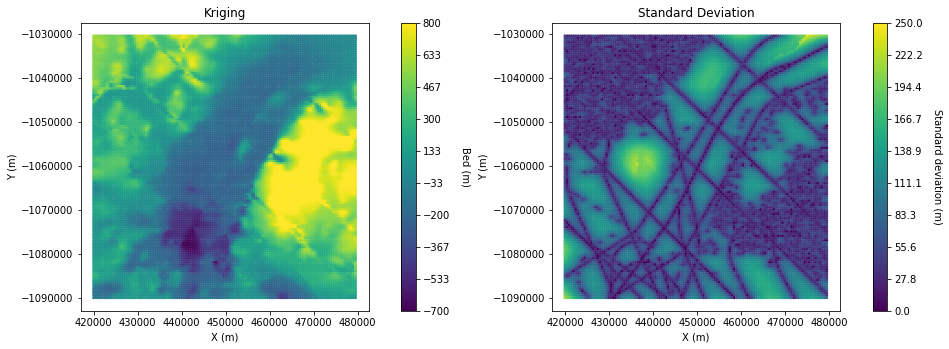

In [11]:
# plot back-transformed results
plt.subplot(121) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = pred_trans, vmin = -700, vmax = 800, marker=".", s = 15)       # scatter plot for location map
plt.title('Kriging')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-700, 800, 10)) # add vertical color bar
cbar.set_label("Bed (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplot(122)
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = std_trans, vmin = 0, vmax = 250, marker=".", s = 15)       # scatter plot for location map
plt.title('Standard Deviation')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, 250, 10)) # add vertical color bar
cbar.set_label("Standard deviation (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

## Spatial statistics

Let's compare the spatial statistics of the data and the kriging interpolation.

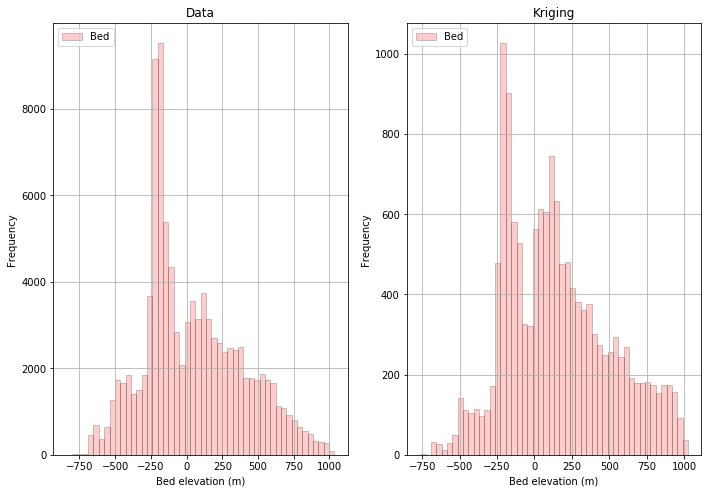

In [12]:
# data histogram
plt.subplot(121)                                    
plt.hist(df_bed['Bed'], facecolor='red',bins=50,alpha=0.2,edgecolor='black',label='Bed')
plt.xlabel('Bed elevation (m)'); plt.ylabel('Frequency'); plt.title('Data')
plt.legend(loc='upper left')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5) # adjust the plot size
plt.grid(True)

# kriging histogram
plt.subplot(122)                                        
plt.hist(pred_trans, facecolor='red',bins=50,alpha=0.2,edgecolor='black',label='Bed')
plt.xlabel('Bed elevation (m)'); plt.ylabel('Frequency'); plt.title('Kriging')
plt.legend(loc='upper left')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5) # adjust the plot size
plt.grid(True)

We can see that the kriging histogram has a greater relative frequency at intermediate values. This because kriging has a smoothing effect. In order to generate topography that reproduces the spatial statistics of the data, stochastic simulation is required.